## Transfer Learning

### ResNet50 불러오기

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [3]:
model = ResNet50(weights='imagenet')

In [4]:
img_path = 'C:/Users/Playdata/Downloads/baseball01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x.shape

(224, 224, 3)

In [5]:
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

In [6]:
pred = model.predict(x)

In [7]:
print('predict:', decode_predictions(pred, top=5)[0])

predict: [('n09835506', 'ballplayer', 0.908418), ('n04228054', 'ski', 0.036202267), ('n02799071', 'baseball', 0.02805831), ('n03134739', 'croquet_ball', 0.009252533), ('n03379051', 'football_helmet', 0.0062576463)]


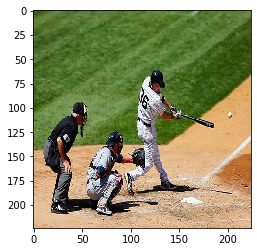

In [8]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

### Extract features VGG16

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [10]:
model_VGG16 = VGG16(weights='imagenet', include_top=False )

In [11]:
img_path = 'C:/Users/Playdata/Downloads/baseball01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [12]:
features = model_VGG16.predict(x)

### VGG19

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

base_model = VGG19(weights='imagenet')
model_VGG19 = Model(inputs=base_model.input, 
                    outputs=base_model.get_layer('block4_pool').output)

574717952/574710816 [==============================] - 50s 0us/step


In [14]:
img_path = 'C:/Users/Playdata/Downloads/baseball01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [15]:
block4_pool_features = model_VGG19.predict(x)

### ResNet 불러온 후 모델 빌드

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
def get_model(num_classes):
    resnet50 = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(32, 32, 3))
    
    x = GlobalAveragePooling2D()(resnet50.output)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs = resnet50.input, outputs = x)
    
    return model

In [18]:
model = get_model(num_classes=10)

94773248/94765736 [==============================] - 11s 0us/step


In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [20]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [22]:
img_path = 'C:/Users/Playdata/Downloads/baseball01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [23]:
resnet_pred = model.predict(x)
print('predict:', decode_predictions(resnet_pred, top=5))

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 10)

### 특정 Feature Extraction Layer를 Base로 받고 + 추가적으로 빌드

In [24]:
def get_model(num_classes):
    
    base_model = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(32, 32, 3))
    
    feature_model = Model(inputs=base_model.input,
                    outputs=base_model.get_layer('conv2_block1_add').output)
    
    x = GlobalAveragePooling2D()(feature_model.output)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs = feature_model.input, outputs = x)
    
    return model

In [25]:
model = get_model(num_classes=10)

In [26]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### Cifar-10으로 학습하기

In [28]:
from tensorflow.keras.datasets import cifar10
import numpy as np

In [29]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [30]:
# 평균과 표준편차는 채널별로 구해줍니다.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

print(x_train.shape, len(y_train))
print(x_val.shape, len(y_val))

(35000, 32, 32, 3) 35000
(15000, 32, 32, 3) 15000


In [32]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/30
 16/274 [>.............................] - ETA: 1:12 - loss: 2.0315 - acc: 0.2783

KeyboardInterrupt: 

# TensorFlow 허브

In [33]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [34]:
import tensorflow_hub as hub

In [37]:
model_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'
hub_eff = hub.KerasLayer(model_url, trainable=False)

In [41]:
model = tf.keras.models.Sequential([
    hub_eff,
    Dense(10, activation='softmax')
    
])

In [44]:
model.compile(optimizer='adam',
              loss='sparse_catgorical_crossentropy',
              metrics=['acc']
             )

In [45]:
model.build([None, 24, 24, 3])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              5330564   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10010     
Total params: 5,340,574
Trainable params: 10,010
Non-trainable params: 5,330,564
_________________________________________________________________
